# $$Shape From Focus (SFF)$$

### Importing Libraries

In [1]:
#Import libraries
from pylab import *
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

### Sum Modified Laplacian 
First we will calculate Modified Laplacian which is given by for the given image I: 
$$ ML=I_{xx} + I_{yy} $$
where $I_{xx}$ and $I_{yy}$ are the discrete 2D double derivatives of the image.
Then we calculate the Sum Modified Laplacian for an image I if $q\geq0$ at $(x,y)$ :
$$ SML(x,y) = \Sigma_{i=-q}^{i=q}\Sigma_{j=-q}^{j=q}ML(x+i,y+j) $$
where $ML$ is the Modified Laplacian of the the image I.For a pixel we will assume the frame which has the maximum Sum Modified Laplacian (SML) at that pixel to be the frame in focus and we will use it for depth estimation. 

Calculate the kernel to obtain the sum modified Laplcian from the modified Laplacian values. For a given q, the kernel is chosen to be a matrix of size 2 * q + 1 with each entry being 1.

We zero pad the image on each side with zeroes of thickness $d$  depending on the use case.

In [2]:
def sml(src,q,delta_d = 50.50) :
    #Obtain partial double derivates (hessian)
    #Compute the second order partial derivatives in x, y directions
    fxx = np.array([[0,0,0],[1,-2,1],[0,0,0]])
    fyy = np.array([[0,1,0],[0,-2,0],[0,1,0]])
    
    d = len(fxx)//2       ## no of rows or columns to be added in the original image 
    Nimg,Nr,Nc = shape(src)   ## obtaining number of images in the stack
    zero_padd_img = np.zeros((Nimg,int(Nr+2*d),int(Nc+2*d))) ## making similar image with zero padding 
    ml = np.zeros(shape(src))                      ## initialising the modified laplacian
    zero_padd_img[:,d:Nr+d,d:Nc+d] = np.copy(src)      ## copying the original image at the centre of zero padded
    patch = np.zeros(shape(fxx))                       ## initialising the patch 
    ## Go along rows and then along columns in the final image after zero padding 
    #Use the second order partial derivatives to compute the modified Laplacian
    for i in range(d,Nr+d)  :
        for j in range(d,Nc+d) :
            patch = zero_padd_img[:,i-d:i+d+1,j-d:j+d+1]  # Taking a patch at a time 
            patch1 = np.sum(patch*fxx,axis = (1,2))         # multiply image patch with the kernel, sum and store
            patch2 = np.sum(patch*fyy,axis = (1,2))         # Same with fxx ## doing convolution 
            #Modified by using abs 
            patch = abs(patch1) + abs(patch2)               ## getting the moddified laplacian on that patch
            ml[:,i-d,j-d] = patch                    ## getting final modified laplacian
    if q != 0 :        ## q is the size of the neighbourhood for the SML window as defined in class
        avg_filter = np.ones((int(2*q+1),int(2*q+1)))/(2*q+1) # Create an averaging filter of size `2 * q + 1` 
        #convolve averaging filter with the modified laplacian('ml') to get `sml`
        d = len(avg_filter)//2                             
        Nimg,Nr,Nc = shape(ml)        ## getting shape of modified laplacian 
        zero_padd_img = np.zeros((Nimg,int(Nr+2*d),int(Nc+2*d)))  ## getting zero padded image 
        sml = np.zeros(shape(ml))   ## initialising the sum modified laplacian 
        zero_padd_img[:,d:Nr+d,d:Nc+d] = ml   ## getting the modified image in the centre of zero padded image 
        patch = np.zeros(shape(avg_filter))   ## initialising the patch 
        #Go along rows and then along columns of the modified zero padded image which has ml in it's centre 
        for i in range(d,Nr+d) :   
            for j in range(d,Nc+d) :  
                patch = zero_padd_img[:,i-d:i+d+1,j-d:j+d+1]   ## getting patches from the modified zero padded image
                patch1 = sum(patch*avg_filter,axis = (1,2))#multiply imag patch with the krnl(avg_filter),sum and store
                sml[:,i-d,j-d] = patch1                   ## final sum modified laplacian 
    else :
        sml = ml        ## if the size of SML window is 0 then sml will be equal to ml
    depth = np.argmax(sml,axis = 0)   
    depth = depth*delta_d     ## getting the depth map    ## delta_d is 50.50
    return depth

### Loading stack.mat file
We load the images from stack.mat. It is presumed to be in the directory. Visualising the $5^{th},50^{th}$ and $80^{th}$ frame.

(100, 115, 115)


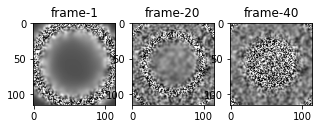

In [3]:
pics = loadmat("stack.mat")  #Loading stack.mat file

#Loading only the images
frames = []               
for i in range(1,10) :
    img = pics["frame00%1d"%i]
    frames.append(img)   
for i in range(10,100) :
    img = pics["frame0%2d"%i]
    frames.append(img)
          
img = pics["frame100"]
frames.append(img)
frames = array(frames)
print(shape(frames))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5, 5))

ax1.imshow(frames[5,:,:], cmap=plt.cm.gray, vmin=0, vmax=255)
ax1.set_title('frame-1')

ax2.imshow(frames[50,:,:], cmap=plt.cm.gray, vmin=0, vmax=255)
ax2.set_title('frame-20')

ax3.imshow(frames[80,:,:], cmap=plt.cm.gray, vmin=0, vmax=255)
ax3.set_title('frame-40')

plt.show()

### Plotting depth map for q=0
Call `sml` with the right arguments to compute `depth_map` with neighborhood sizes as q=0.

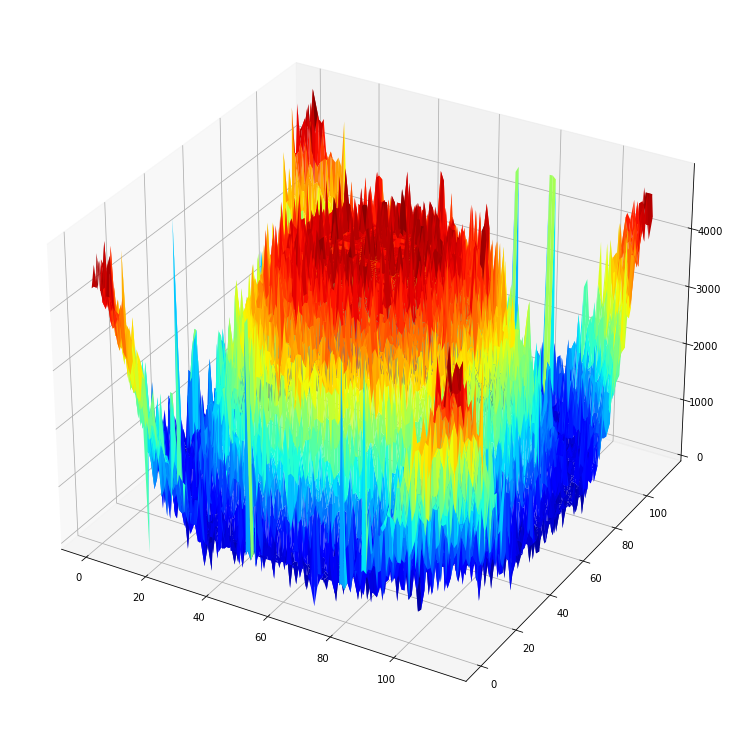

In [4]:
depth0 = sml(src = frames,q = 0)
#print(depth)

#Plot depth map
X = np.arange(len(depth0))
Y = np.arange(len(depth0[0]))
X,Y = meshgrid(X,Y)
fig = plt.figure(figsize=(10,15))
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, depth0, rstride=1, cstride=1, cmap=cm.jet, linewidth=1, antialiased=True)
#plt.legend()
plt.show()

### Plotting depth map for q = 1 
Call `sml` with the right arguments to compute `depth_map` with neighborhood sizes as q=1.

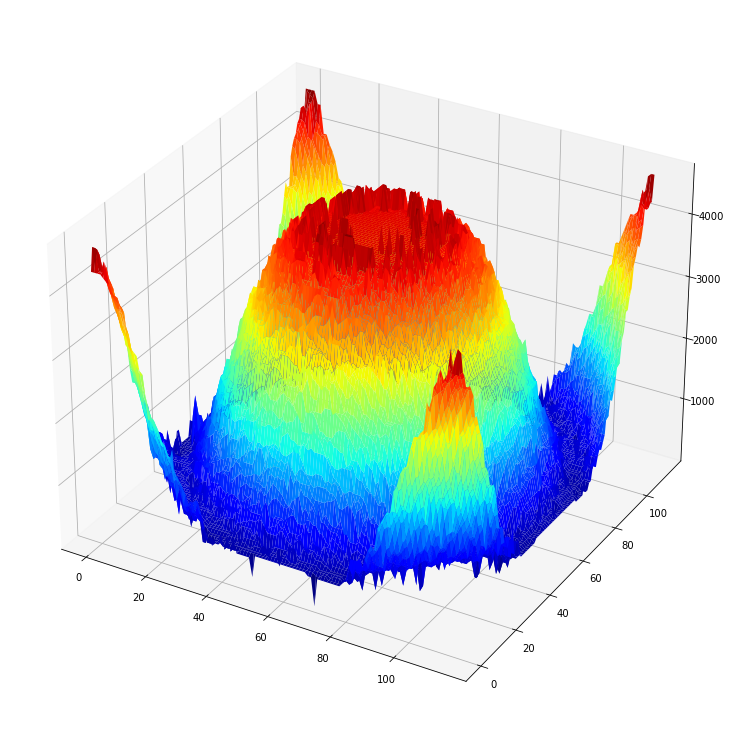

In [5]:
depth1 = sml(src = frames,q = 1)
#print(depth)

#Plot depth map
X = np.arange(len(depth1))
Y = np.arange(len(depth1[0]))
X,Y = meshgrid(X,Y)
fig = plt.figure(figsize=(10,15))
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, depth1, rstride=1, cstride=1, cmap=cm.jet, linewidth=1, antialiased=True)
#plt.legend()
plt.show()

### Plotting depth map for q = 2
Call `sml` with the right arguments to compute `depth_map` with neighborhood sizes as q=2.

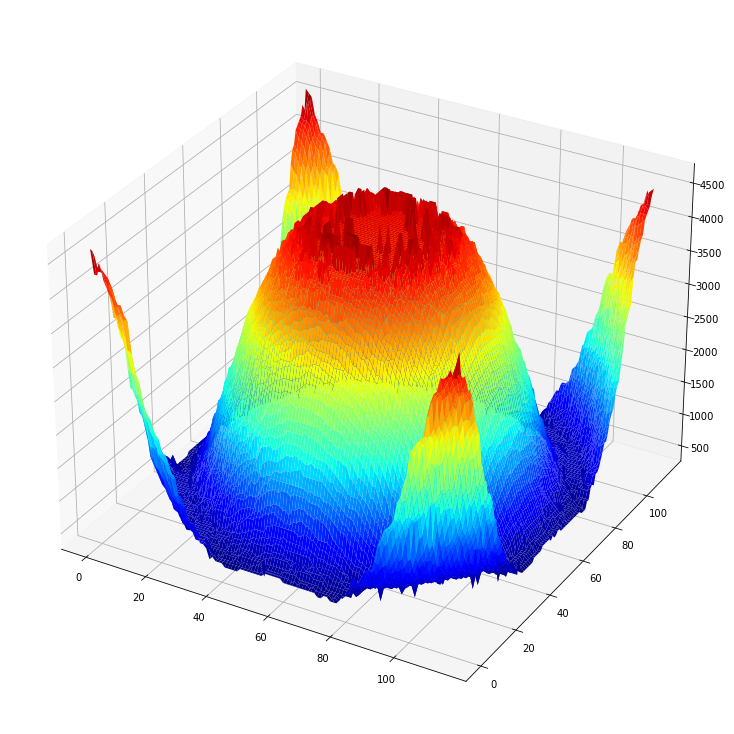

In [6]:
depth2 = sml(src = frames,q = 2)
#print(depth)

#Plot depth map
X = np.arange(len(depth2))
Y = np.arange(len(depth2[0]))
X,Y = meshgrid(X,Y)
fig = plt.figure(figsize=(10,15))
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, depth2, rstride=1, cstride=1, cmap=cm.jet, linewidth=1, antialiased=True)
#fig.colorbar(surface)
#plt.legend()
plt.show()

### Observations

    The depth estimates are noticeably different for all three cases. As the size of SML window (q) increases, 
    we get smoother estimates.
